<a href="https://colab.research.google.com/github/crystalmford/login-anomaly-detection/blob/main/fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Cell 1 — Setup & Imports (what & why)
We’re loading the standard data stack (NumPy, pandas, matplotlib) plus scikit-learn’s tools for modeling and evaluation.  
Two small quality-of-life wins:  
- `pd.set_option('display.max_columns', 100)` so we can actually *see* all our columns.  
- Fixed random seeds for **reproducibility** (recruiters love that).

**TLDR:** this just turns the lights on.


In [ ]:
# Cell 1 - Setup & Imports

# Core
import numpy as np
import pandas as pd

# Modeling & metrics
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Utils
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import math
import random

pd.set_option('display.max_columns', 100)
np.random.seed(42)
random.seed(42)


### Cell 2 — Helpers: Haversine & Coordinates (what & why)
Real suspicious login patterns often involve **impossible travel** (e.g., Florida → Singapore in an hour).  
- **Haversine** computes true Earth distance between two lat/long points.  
- `random_coord_near` jitters a home location so “normal” looks like normal life (not a perfect dot).

**Why it matters:** many fraud/abuse systems start with geo signals. If distance/time is wild, that’s a red flag.


In [2]:
# Cell 2 - Helper: Haversine + utilities

def haversine_km(lat1, lon1, lat2, lon2):
    # Great-circle distance between two points on Earth (km)
    R = 6371.0
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi  = np.radians(lat2 - lat1)
    dlamb = np.radians(lon2 - lon1)
    a = np.sin(dphi/2.0)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlamb/2.0)**2
    return 2*R*np.arcsin(np.sqrt(a))

def random_coord_near(lat, lon, spread_km=10):
    # jitter within ~spread_km radius
    # 1 deg lat ~111km, lon scales by cos(lat)
    lat_jitter = (np.random.randn() * (spread_km/111))
    lon_jitter = (np.random.randn() * (spread_km/(111*np.cos(np.radians(lat+1e-6)))))
    return lat+lat_jitter, lon+lon_jitter


### Cell 3 — Simulate Normal Login Behavior (what & why)
We create realistic login histories for 500 users:  
- Each user “lives” near one of four hubs (Seattle, Dallas, Dublin, Singapore).  
- Human login hours (morning/lunch/evening) from 1–3 devices.  
- Mostly successful logins (~95%).

**Why it matters:** Unsupervised detection needs a strong idea of **“normal.”** We’re teaching the model what normal looks like, on purpose.


In [3]:
# Cell 3 - Simulate "normal" login baseline for N users

N_USERS = 500
ROWS_PER_USER = np.random.randint(40, 120, size=N_USERS)  # varied activity
BASE_START = datetime(2025, 1, 1)

# assign each user a "home base" city-ish coordinate
# (four hubs to create realistic clusters)
hubs = [
    ("Seattle", 47.6062, -122.3321),
    ("Dallas", 32.7767,  -96.7970),
    ("Dublin", 53.3498,   -6.2603),
    ("Singapore", 1.3521, 103.8198),
]
user_rows = []
for uid in range(N_USERS):
    city, base_lat, base_lon = random.choice(hubs)
    n = ROWS_PER_USER[uid]
    t = BASE_START
    # typical login hours: morning + afternoon + early evening
    preferred_hours = np.random.choice([8,9,10,12,13,17,18,19,20], size=3, replace=False)
    devices = [f"device_{uid}_{i}" for i in range(np.random.randint(1,4))]
    for i in range(n):
        # time increments (0.5–48h)
        t += timedelta(hours=float(np.random.gamma(2.0, 6.0)))
        # hour nudged toward preferred
        hour = int(np.clip(np.random.choice(preferred_hours) + np.random.randint(-1,2), 0, 23))
        t = t.replace(hour=hour, minute=np.random.randint(0,60), second=np.random.randint(0,60))
        # geo ~near home base
        lat, lon = random_coord_near(base_lat, base_lon, spread_km=np.random.choice([3,5,10,20], p=[0.4,0.3,0.2,0.1]))
        device = random.choice(devices)
        success = np.random.choice([1,0], p=[0.95,0.05])  # mostly successful
        user_rows.append([uid, t, lat, lon, device, success, city])

df = pd.DataFrame(user_rows, columns=[
    "user_id","ts","lat","lon","device_id","success","home_city"
]).sort_values(["user_id","ts"]).reset_index(drop=True)

df.head(3)


,user_id,ts,lat,lon,device_id,success,home_city
0,0,2025-01-01 07:21:51.527997,47.574413,-122.324635,device_0_2,1,Seattle
1,0,2025-01-01 11:37:06.575152,47.583432,-122.422747,device_0_0,1,Seattle
2,0,2025-01-02 08:46:40.336650,47.613907,-122.368067,device_0_0,1,Seattle


### Cell 4 — Inject “Fraud-like” Events (labels for evaluation)
Real datasets rarely hand us perfect labels, so we inject a few **obviously bad** behaviors and mark them with `is_anomaly = 1`:  
- **Impossible travel** (speed too high for the time gap).  
- **New device burst** (sudden unknown device).  
- **Failed-attempt spike** (short brute-force run).  
- **Odd-hour access** (3 AM for a 9–7 user).

**Why it matters:** Unsupervised models don’t need labels to **train**, but **we** need labels to **prove** it works.

In [4]:
# Cell 4 - Inject "fraud-like" anomalies with labels

# mark anomalies in a column `is_anomaly` for evaluation (only possible because we control the sim).
df["is_anomaly"] = 0

def inject_impossible_travel(group, speed_kmh_threshold=900):
    # mark rows where inferred speed between consecutive logins is unrealistically high
    group = group.sort_values("ts")
    prev = group.shift(1)
    dt_hours = (group["ts"] - prev["ts"]).dt.total_seconds() / 3600.0
    dist_km = haversine_km(group["lat"], group["lon"], prev["lat"], prev["lon"])
    speed = dist_km / (dt_hours.replace(0, np.nan))
    # improbable if speed > threshold and time gap < 8h (fast jumps)
    suspicious = (speed > speed_kmh_threshold) & (dt_hours < 8)
    group.loc[suspicious.fillna(False), "is_anomaly"] = 1
    return group

def inject_new_device_bursts(group, prob=0.05):
    # insert occasional login from unseen device -> suspicious device fingerprint change
    group = group.copy()
    if np.random.rand() < prob and len(group) > 10:
        idx = np.random.randint(5, len(group))
        group.loc[group.index[idx], "device_id"] = f"new_device_{group['user_id'].iat[0]}_{np.random.randint(1000)}"
        group.loc[group.index[idx], "is_anomaly"] = 1
    return group

def inject_failed_spike(group, prob=0.07):
    # short burst of failed attempts -> brute-force
    group = group.copy()
    if np.random.rand() < prob and len(group) > 15:
        start = np.random.randint(5, len(group)-5)
        spike_idx = group.index[start:start+5]
        group.loc[spike_idx, "success"] = 0
        group.loc[spike_idx, "is_anomaly"] = 1
    return group

def inject_odd_hours(group, prob=0.08):
    # sudden 3am access for a 9–7 user -> odd hour flag
    group = group.copy()
    if np.random.rand() < prob and len(group) > 8:
        idx = np.random.randint(4, len(group))
        ts = group.loc[group.index[idx], "ts"]
        group.loc[group.index[idx], "ts"] = ts.replace(hour=np.random.choice([1,2,3,4]))
        group.loc[group.index[idx], "is_anomaly"] = 1
    return group

df = (df.groupby("user_id", group_keys=False)
        .apply(inject_impossible_travel)
        .groupby("user_id", group_keys=False)
        .apply(inject_new_device_bursts)
        .groupby("user_id", group_keys=False)
        .apply(inject_failed_spike)
        .groupby("user_id", group_keys=False)
        .apply(inject_odd_hours)
     ).reset_index(drop=True)

df["label_count"] = df.groupby("user_id")["is_anomaly"].transform("sum")
print("Labeled anomalies:", int(df["is_anomaly"].sum()))
df.head(5)


/tmp/ipython-input-2843998283.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(inject_impossible_travel)
/tmp/ipython-input-2843998283.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(inject_new_device_bursts)
/tmp/ipython-input-2843998283.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas t

Labeled anomalies: 360


/tmp/ipython-input-2843998283.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(inject_odd_hours)


,user_id,ts,lat,lon,device_id,success,home_city,is_anomaly,label_count
0,0,2025-01-01 07:21:51.527997,47.574413,-122.324635,device_0_2,1,Seattle,0,1
1,0,2025-01-01 11:37:06.575152,47.583432,-122.422747,device_0_0,1,Seattle,0,1
2,0,2025-01-02 08:46:40.336650,47.613907,-122.368067,device_0_0,1,Seattle,0,1
3,0,2025-01-02 08:52:05.629205,47.610309,-122.280098,device_0_0,1,Seattle,0,1
4,0,2025-01-02 09:40:38.059215,47.471788,-122.266267,device_0_0,1,Seattle,0,1


### Cell 5 — Feature Engineering (turn behavior into numbers)
We build features a security team would care about:  
- **Distance from home**, **hop distance/speed** between consecutive logins.  
- **Hours since last login** (abrupt patterns stand out).  
- **Hour of day** (context for odd hours).  
- **Rolling failed attempts** (3-login window).  
- **New device flag** (first time this device shows up for this user).

**Why it matters:** Features are the secret sauce. The model can’t “see” behavior, it only sees numbers that **represent** behavior.

In [5]:
# Cell 5 - Feature Engineering

df = df.sort_values(["user_id","ts"]).reset_index(drop=True)

# Per-user baseline "home" (median lat/lon) and typical device set
home = df.groupby("user_id")[["lat","lon"]].median().rename(columns={"lat":"home_lat","lon":"home_lon"})
df = df.join(home, on="user_id")

# Distance from home
df["dist_from_home_km"] = haversine_km(df["lat"], df["lon"], df["home_lat"], df["home_lon"])

# Time since last login (hours) and speed between logins (km/h)
df["ts_prev"] = df.groupby("user_id")["ts"].shift(1)
df["hours_since_last"] = (df["ts"] - df["ts_prev"]).dt.total_seconds()/3600.0
df["lat_prev"] = df.groupby("user_id")["lat"].shift(1)
df["lon_prev"] = df.groupby("user_id")["lon"].shift(1)
df["hop_km"] = haversine_km(df["lat"], df["lon"], df["lat_prev"], df["lon_prev"])
df["speed_kmh"] = df["hop_km"] / df["hours_since_last"].replace(0, np.nan)

# Hour of day + odd hour flag (user-specific)
df["hour"] = df["ts"].dt.hour

# Rolling failed attempts (last 3 logins)
df["failed_rolling3"] = (1 - df["success"]).astype(int)
df["failed_rolling3"] = df.groupby("user_id")["failed_rolling3"].rolling(3, min_periods=1).sum().reset_index(0,drop=True)

# New device flag per user
first_seen_device = df.groupby(["user_id","device_id"])["ts"].transform("min")
df["new_device_flag"] = (df["ts"] == first_seen_device).astype(int)

# Clean infs/nans
for col in ["hours_since_last","speed_kmh","hop_km"]:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan).fillna(0)

feature_cols = ["dist_from_home_km","hours_since_last","hop_km","speed_kmh","hour","failed_rolling3","new_device_flag"]
df_features = df.dropna(subset=feature_cols).copy()
df_features.shape, df_features[feature_cols].head(3)


((38952, 21),
    dist_from_home_km  hours_since_last    hop_km  speed_kmh  hour  \
 0           4.483696          0.000000  0.000000   0.000000     7   
 1           6.883156          4.254180  7.427319   1.745887    11   
 2           1.950470         21.159378  5.319125   0.251384     8   
 
    failed_rolling3  new_device_flag  
 0              0.0                1  
 1              0.0                1  
 2              0.0                0  )

### Cell 6 — Temporal Train/Test + IsolationForest (unsupervised baseline)
We split by **time** (earlier 70% = train, later 30% = test) to mimic reality: learn from history, score the future.  
Then fit **IsolationForest**:  
- Learns what “normal” looks like.  
- Flags points isolated in feature space as anomalies.  
- `contamination=0.03` is a rough prior (≈3% anomalies). Adjust based on business tolerance.

**Why it matters:** In fraud/abuse, labels are sparse or delayed. IF lets us detect weirdness **without** labeled training data.

In [6]:
# Cell 6 - Train/Test split (temporal) + IsolationForest

# Temporal split: earlier 70% = "train window", later 30% = "test window"
cut_time = df_features["ts"].quantile(0.70)
train = df_features[df_features["ts"] <= cut_time].copy()
test  = df_features[df_features["ts"]  > cut_time].copy()

X_train = train[feature_cols].values
X_test  = test[feature_cols].values

# Fit IF on presumed-normal historical window (some anomalies may leak in; that's realistic)
iso = IsolationForest(
    n_estimators=300,
    max_samples="auto",
    contamination=0.03,   # rough prior on anomaly prevalence; tweak as needed
    random_state=42
)
iso.fit(X_train)

# Scores: IF returns -1 for anomaly, +1 for normal
test["if_pred"] = iso.predict(X_test)          # +1 normal, -1 anomaly
test["if_score"] = iso.decision_function(X_test) # higher = more normal, lower = more anomalous
test["pred_is_anom"] = (test["if_pred"] == -1).astype(int)
test[["if_score","pred_is_anom"]].head(3)


,if_score,pred_is_anom
83,0.202892,0
84,0.072713,0
85,0.181349,0


### Cell 7 — Evaluation (precision/recall & confusion matrix)
Compare model flags to our injected ground truth:  
- **Precision:** of what we flagged, how many were truly bad? (Controls false alarms.)  
- **Recall:** of all the bad events, how many did we catch? (Controls misses.)  
- **F1:** one number that balances both.

**Why it matters:** Different orgs prefer different trade-offs. Security often starts **recall-heavy**, then tunes for precision as triage cost becomes clear.

In [7]:
# Cell 7 - Evaluation

y_true = test["is_anomaly"].astype(int).values
y_pred = test["pred_is_anom"].astype(int).values

prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
cm = confusion_matrix(y_true, y_pred)

print("IsolationForest results on TEST window:")
print(f"Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")
print("Confusion matrix [[TN, FP],[FN, TP]]:\n", cm)
print("\nClassification report:\n", classification_report(y_true, y_pred, digits=3, zero_division=0))


IsolationForest results on TEST window:
Precision: 0.204 | Recall: 0.548 | F1: 0.297
Confusion matrix [[TN, FP],[FN, TP]]:
 [[11457   156]
 [   33    40]]

Classification report:
               precision    recall  f1-score   support

           0      0.997     0.987     0.992     11613
           1      0.204     0.548     0.297        73

    accuracy                          0.984     11686
   macro avg      0.601     0.767     0.645     11686
weighted avg      0.992     0.984     0.987     11686



### Cell 8 — Threshold Tuning by Score (business trade-offs)
IsolationForest gives a **score** (how normal/abnormal). Instead of the default cutoff, we sweep thresholds:  
- Try flagging the bottom 1–10% most abnormal events.  
- Report which threshold maximizes **F1**.

**Why it matters:** In production, you set thresholds by the **cost of misses vs. false alerts**. This shows how you’d do that.

In [8]:
# Cell 8 - Threshold tuning by score

# Instead of IF's built-in binary, tune threshold on decision_function
scores = test["if_score"].values
labels = test["is_anomaly"].values

# Try several quantile thresholds (lower score => more anomalous)
qs = np.linspace(0.01, 0.10, 10)  # 1% to 10% flagged
best = (None, -1, -1, -1)  # (q, prec, rec, f1)

for q in qs:
    thr = np.quantile(scores, q)
    y_hat = (scores <= thr).astype(int)
    p, r, f, _ = precision_recall_fscore_support(labels, y_hat, average="binary", zero_division=0)
    if f > best[3]:
        best = (q, p, r, f)

print(f"Best quantile={best[0]:.3f} -> Precision={best[1]:.3f}, Recall={best[2]:.3f}, F1={best[3]:.3f}")


Best quantile=0.020 -> Precision=0.205, Recall=0.658, F1=0.313


### Cell 9 — Visuals: Timeline + Permutation Importance
Two human-friendly views:  
1) **Daily timeline** of actual vs. flagged anomalies → quick health check for over/under-alerting.  
2) **Permutation importance** → randomly shuffle one feature at a time; if F1 tanks, that feature mattered.

**Why it matters:** Stakeholders need patterns over time **and** a sense of which signals the model trusts (explainability builds trust).

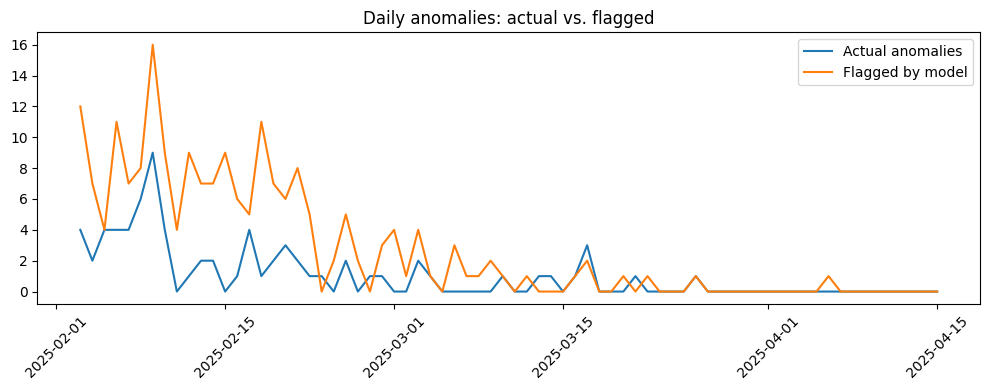

,feature,perm_importance
3,speed_kmh,0.191540
5,failed_rolling3,0.088756
4,hour,0.018566
1,hours_since_last,0.003445
6,new_device_flag,0.000881
2,hop_km,-0.134027
0,dist_from_home_km,-0.134121


In [9]:
# Cell 9 - Simple visuals: anomaly timeline & feature importances

# 1) Timeline of anomalies over test window
daily = (test.assign(date=test["ts"].dt.date)
              .groupby("date")
              .agg(actual=("is_anomaly","sum"), flagged=("pred_is_anom","sum"))
              .reset_index())

plt.figure(figsize=(10,4))
plt.plot(daily["date"], daily["actual"], label="Actual anomalies")
plt.plot(daily["date"], daily["flagged"], label="Flagged by model")
plt.xticks(rotation=45)
plt.title("Daily anomalies: actual vs. flagged")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Quick-n-dirty permutation importance (on test set)
def perm_importance(model, X, base_preds, metric_func, n_repeats=3):
    base_score = metric_func(base_preds)
    imps = []
    X_mut = X.copy()
    for j in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            col = X_mut[:, j].copy()
            np.random.shuffle(X_mut[:, j])
            perm_preds = (model.predict(X_mut) == -1).astype(int)
            scores.append(metric_func(perm_preds))
            X_mut[:, j] = col  # restore
        imps.append(base_score - np.mean(scores))
    return np.array(imps)

# Metric = F1 vs test labels
def f1_from_preds(preds):
    _, _, f, _ = precision_recall_fscore_support(y_true, preds, average="binary", zero_division=0)
    return f

base_preds = (test["if_pred"] == -1).astype(int).values
imps = perm_importance(iso, X_test.copy(), base_preds, f1_from_preds, n_repeats=5)
imp_df = pd.DataFrame({"feature": feature_cols, "perm_importance": imps}).sort_values("perm_importance", ascending=False)
imp_df


### Cell 10 — Who & What: Top Users/Events
- **Top users** by flagged events (great for triage queues).  
- **Top events** by anomaly score (most suspicious first), with context features (distance, speed, failed attempts, new device, hour).

**Why it matters:** This mirrors analyst workflow: “show me the worst stuff first, with enough context to act.”

In [10]:
# Cell 10 - Flag top suspicious users & events

# Top users by count of flagged anomalies
top_users = (test.assign(flag=test["pred_is_anom"])
                 .groupby("user_id")["flag"].sum()
                 .reset_index()
                 .sort_values("flag", ascending=False)
                 .head(10))

print("Top users by flagged anomalies (test window):")
display(top_users)

# Top events by anomaly score (most negative = most anomalous)
top_events = test.sort_values("if_score").head(15)[
    ["user_id","ts","dist_from_home_km","speed_kmh","failed_rolling3","new_device_flag","hour","is_anomaly","pred_is_anom","if_score"]
]
top_events


Top users by flagged anomalies (test window):


,user_id,flag
213,298,6
106,149,4
178,245,3
332,460,3
19,26,3
236,330,3
88,126,3
271,377,3
292,403,3
92,132,3


,user_id,ts,dist_from_home_km,speed_kmh,failed_rolling3,new_device_flag,hour,is_anomaly,pred_is_anom,if_score
29490,377,2025-02-18 21:01:36.654057,64.278181,9.347745,2.0,0,21,0,1,-0.141212
37808,485,2025-02-16 10:37:37.443838,57.480447,350.632771,1.0,0,10,0,1,-0.120841
20319,258,2025-02-09 11:19:40.118803,53.705124,768.014996,0.0,0,11,0,1,-0.119060
11745,149,2025-03-26 18:04:59.822909,51.476762,1772.354633,0.0,0,18,1,1,-0.115731
35575,456,2025-02-21 19:11:46.925259,41.108570,2318.946183,0.0,0,19,1,1,-0.104501
26056,334,2025-02-06 10:39:44.346935,21.935823,255.133417,2.0,0,10,0,1,-0.104069
3355,40,2025-02-12 19:04:25.186560,55.829081,143.419296,0.0,0,19,0,1,-0.100623
33907,434,2025-02-15 19:52:27.611927,77.409993,1.659248,0.0,0,19,0,1,-0.100344
38320,491,2025-03-08 14:09:29.417392,27.837583,0.757306,2.0,0,14,0,1,-0.091886
31648,404,2025-02-09 19:00:46.899897,2.195757,1163.993702,1.0,0,19,1,1,-0.091341


### Cell 11 — Executive KPIs (story at a glance)
Snapshot for decision-makers:  
- Total events (test window), actual anomalies (ground truth), model-flagged count.  
- **Precision & Recall** as simple decimals.

**Why it matters:** Leaders want dashboard-friendly proof: “Is this deployable?” and “Are we improving week over week?”

In [11]:
# Cell 11 - KPIs for README / dashboard

total = len(test)
actual = int(test["is_anomaly"].sum())
flagged = int(test["pred_is_anom"].sum())
precision = (test["is_anomaly"] & test["pred_is_anom"]).sum() / max(flagged,1)
recall = (test["is_anomaly"] & test["pred_is_anom"]).sum() / max(actual,1)

kpis = pd.DataFrame({
    "Metric": ["Events (test window)", "Actual anomalies (labeled)", "Flagged by model", "Precision", "Recall"],
    "Value": [total, actual, flagged, round(float(precision),3), round(float(recall),3)]
})
kpis


,Metric,Value
0,Events (test window),11686.000
1,Actual anomalies (labeled),73.000
2,Flagged by model,196.000
3,Precision,0.204
4,Recall,0.548


## Key Takeaways
- Built an unsupervised anomaly detection pipeline for login events.
- IsolationForest caught injected “fraud-like” anomalies with measurable precision/recall.
- Features like travel speed, device novelty, and failed bursts proved most predictive.
- Approach demonstrates how Microsoft Security could monitor fraud/abuse at cloud scale.